In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
! pip install seaborn==0.9.0

    100% |████████████████████████████████| 215kB 12.1MB/s ta 0:00:01
  Found existing installation: seaborn 0.8.1
    Uninstalling seaborn-0.8.1:
      Successfully uninstalled seaborn-0.8.1


## Context
There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. 
Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. 
Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

We present a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. 
PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour 
to later evaluate the performance of fraud detection methods.

Content
PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. 
The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

This synthetic dataset is scaled down 1/4 of the original dataset and it is created just for Kaggle.

### Headers
This is a sample of 1 row with headers explanation:

1,PAYMENT,1060.31,C429214117,1089.0,28.69,M1591654462,0.0,0.0,0,0

 - step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

 - type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

 - amount - amount of the transaction in local currency.

 - nameOrig - customer who started the transaction

 - oldbalanceOrg - initial balance before the transaction

 - newbalanceOrig - new balance after the transaction

 - nameDest - customer who is the recipient of the transaction

 - oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

 - newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

 - isFraud - This is the transactions made by the fraudulent agents inside the simulation. 
             In this specific dataset the fraudulent behavior of the agents aims to profit by taking control 
              or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

 - isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. 
                    An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

Past Research
There are 5 similar files that contain the run of 5 different scenarios. These files are better explained at my PhD thesis chapter 7 (PhD Thesis Available here http://urn.kb.se/resolve?urn=urn:nbn:se:bth-12932).

We ran PaySim several times using random seeds for 744 steps, representing each hour of one month of real time, which matches the original logs. 
Each run took around 45 minutes on an i7 intel processor with 16GB of RAM. 
The final result of a run contains approximately 24 million of financial records divided into the 5 types of categories: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

Acknowledgements
This work is part of the research project ”Scalable resource-efficient systems for big data analytics” funded
by the Knowledge Foundation (grant: 20140032) in Sweden.

Please refer to this dataset using the following citations:

PaySim first paper of the simulator:

E. A. Lopez-Rojas , A. Elmir, and S. Axelsson. "PaySim: A financial mobile money simulator for fraud detection". In: The 28th European Modeling and Simulation Symposium-EMSS, Larnaca, Cyprus. 2016

In [3]:
# labrary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html
from itertools import chain,cycle

# deactivate scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
# useful functions

def describe(df, stats):
    """using the pandas describe method and adding more information to it
       
       INPUT: df = dataframe in question
              stats = extra stats needed
              
       OUTPUT: dataframe with stats for the numric columns of the dataset"""
    d = df.describe()
    return d.append(df.reindex(d.columns, axis = 1).agg(stats))


def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [18]:
# read data
data = pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,0.000
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,0.000
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,0.000
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,0.000
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,0.000


## Exploratory Analysis

1) describe data

2) drop missing values/rows

3) check the target flags per type

4) check validity of 'newbalanceOrig' field

5) check if isFraud is correclty as per the definition

6) create C/M flags for Org-Dest entities                         - EXPLORE

7) collect all orig/den that are involed in a fraud (isFraud = 1) - THINK WHAT TO DO WITH THAt

8) create direction of transactions overall for each custom within the dataset

### 1)describe data

In [15]:

print("data shape : {}\n".format(data.shape))
display(data.info())

display(describe(data, ['skew', 'mad', 'kurt', 'sum']))


data shape : (4693572, 14)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4693572 entries, 0 to 4693571
Data columns (total 14 columns):
step                         int64
type                         object
amount                       float64
nameOrig                     object
oldbalanceOrg                float64
newbalanceOrig               float64
nameDest_x                   object
oldbalanceDest               float64
newbalanceDest               float64
isFraud                      float64
isFlaggedFraud               float64
origEntity_trxCnt_origPos    int64
origEntity_trxCnt_destPos    float64
origEntity_trxCnt            int64
dtypes: float64(8), int64(3), object(3)
memory usage: 537.1+ MB


None

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt
count,4693572.000,4693572.000,4693572.000,4693572.000,4693571.000,4693571.000,4693571.000,4693571.000,4693572.000,1001.000,4693572.000
mean,181.574,180175.021,840375.260,862111.769,1053693.336,1184523.670,0.001,0.000,1.002,7.461,1.002
std,99.363,652119.942,2913602.980,2950268.710,2996798.067,3371071.491,0.028,0.001,0.047,7.971,0.047
min,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000
25%,132.000,13097.843,0.000,0.000,0.000,0.000,0.000,0.000,1.000,2.000,1.000
50%,189.000,75691.155,14057.000,0.000,136790.200,220114.430,0.000,0.000,1.000,5.000,1.000
75%,259.000,209478.315,107915.000,146472.955,944709.845,1118495.210,0.000,0.000,1.000,10.000,1.000
max,331.000,92445516.640,43818855.300,43686616.330,355553416.300,355553416.300,1.000,1.000,3.000,56.000,3.000
skew,-0.386,32.203,5.216,5.147,18.535,19.104,35.454,1250.808,21.365,2.180,21.365
mad,82.473,181930.825,1377251.685,1408640.286,1344363.094,1463311.662,0.002,0.000,0.004,5.785,0.004


### 2)drop missing values/rows

In [53]:
# drop the following row:
display(data.loc[(data['isFlaggedFraud'].isnull())|(data['isFraud'].isnull())])

# 1 record does not have target variable available. Drop this record as it adds up to nothing
data = data.loc[(data['isFlaggedFraud'].notna())|(data['isFraud'].notna())]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos,name,destEntity_trxCnt
4693571,331,CASH_IN,4683.280,C212390777,21788.000,26471.280,C154711,nan,nan,nan,nan,1,nan,1,1,nan,C154711,1


### min max amount, org_init_balance, ben_init_balance of the different types

In [54]:
agg_functions = ['min','max']
data[['type','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions})

amount              oldbalanceOrg              oldbalanceDest  \
            min          max           min          max            min   
type                                                                     
CASH_IN   0.960  1915267.900         0.000 38939424.030          0.000   
CASH_OUT  0.000 10000000.000         0.000 43818855.300          0.000   
DEBIT     0.550   569077.510         0.000  4362014.110        221.000   
PAYMENT   0.020   197201.170         0.000 43686616.330          0.000   
TRANSFER  2.600 92445516.640         0.000 37670038.080          0.000   

                        
                   max  
type                    
CASH_IN  355553416.300  
CASH_OUT 311404901.410  
DEBIT    235951203.460  
PAYMENT          0.000  
TRANSFER 324915061.410

### 3)check the target flags per type

In [55]:
agg_functions = ['min','max']
data[['type','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']})

amount              oldbalanceOrg               \
                     min          max           min          max   
type     isFraud                                                   
CASH_IN  0.000     0.960  1915267.900         0.000 38939424.030   
CASH_OUT 0.000     0.370  2847566.620         0.000 43818855.300   
         1.000     0.000 10000000.000         0.000 10000000.000   
DEBIT    0.000     0.550   569077.510         0.000  4362014.110   
PAYMENT  0.000     0.020   197201.170         0.000 43686616.330   
TRANSFER 0.000     2.600 92445516.640         0.000 25908675.060   
         1.000   119.000 10000000.000         0.000 37670038.080   

                 oldbalanceDest                isFraud           
                            min           max    count      sum  
type     isFraud                                                 
CASH_IN  0.000            0.000 355553416.300  1028902    0.000  
CASH_OUT 0.000            0.000 311404901.410  1665729    0.000  
         1.000            0.000  32961658.250     1872 1872.000  
DEBIT    0.000          221.000 235951203.460    29203    0.000  
PAYMENT  0.000            0.000         0.000  1578507    0.000  
TRANSFER 0.000            0.000 324915061.410   387505    0.000  
         1.000            0.000   2122336.550     1853 1853.000

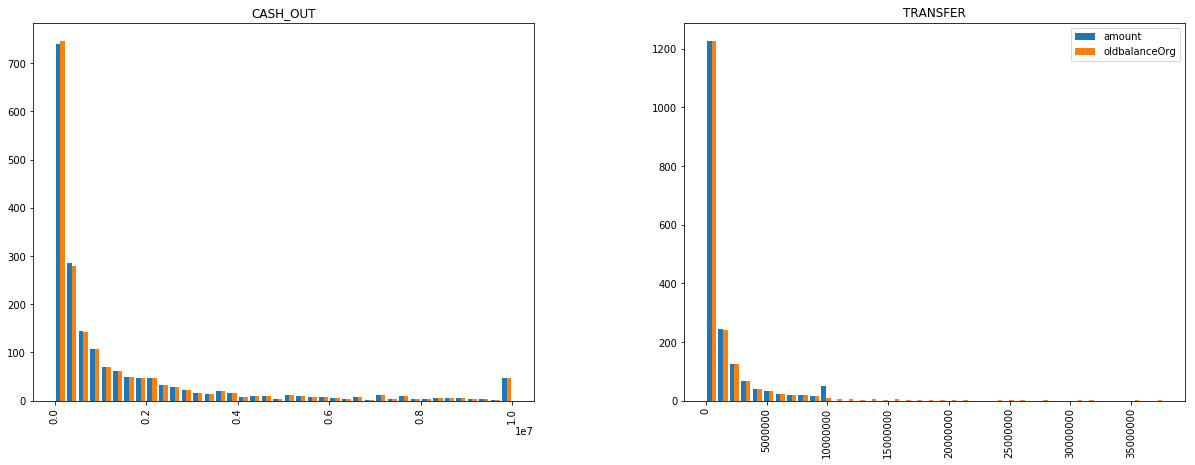

In [56]:
Fraud_cshout_transfer = data.loc[(data['type'].isin(['CASH_OUT','TRANSFER']))&(data['isFraud'] == 1)]

Fraud_cshout_transfer[['amount','oldbalanceOrg']].hist(bins=40, figsize=(20, 7), sharex=False, sharey=False, by=Fraud_cshout_transfer['type'],label=['amount','oldbalanceOrg'])
plt.ticklabel_format(style='plain')
plt.legend(prop={'size': 10})
plt.show()

### 6)create C/M flags for Org-Dest entities - explore

In [57]:
# extract C/M flags for Org-Dest entities

data['ext_org_ind'] = data['nameOrig'].str[:1]
display(data[['ext_org_ind','nameOrig']].groupby('ext_org_ind').agg({'nameOrig':['count','nunique']}))
data['ext_den_ind'] = data['nameDest'].str[:1]
display(data[['ext_den_ind','nameDest']].groupby('ext_den_ind').agg({'nameDest':['count','nunique']}))

nameOrig         
               count  nunique
ext_org_ind                  
C            4693571  4688416

nameDest         
               count  nunique
ext_den_ind                  
C            3115064   421322
M            1578507  1577905

In [58]:
#oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

#newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

agg_functions = ['min','max']
display(data[['ext_org_ind','ext_den_ind','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['ext_org_ind','ext_den_ind','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))

display(data[['type','ext_org_ind','ext_den_ind','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['type','ext_org_ind','ext_den_ind','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))

amount              oldbalanceOrg  \
                                   min          max           min   
ext_org_ind ext_den_ind isFraud                                     
C           C           0.000    0.370 92445516.640         0.000   
                        1.000    0.000 10000000.000         0.000   
            M           0.000    0.020   197201.170         0.000   

                                             oldbalanceDest                \
                                         max            min           max   
ext_org_ind ext_den_ind isFraud                                             
C           C           0.000   43818855.300          0.000 355553416.300   
                        1.000   37670038.080          0.000  32961658.250   
            M           0.000   43686616.330          0.000         0.000   

                                 isFraud           
                                   count      sum  
ext_org_ind ext_den_ind isFraud                    
C           C           0.000    3111339    0.000  
                        1.000       3725 3725.000  
            M           0.000    1578507    0.000

amount              oldbalanceOrg  \
                                             min          max           min   
type     ext_org_ind ext_den_ind isFraud                                      
CASH_IN  C           C           0.000     0.960  1915267.900         0.000   
CASH_OUT C           C           0.000     0.370  2847566.620         0.000   
                                 1.000     0.000 10000000.000         0.000   
DEBIT    C           C           0.000     0.550   569077.510         0.000   
PAYMENT  C           M           0.000     0.020   197201.170         0.000   
TRANSFER C           C           0.000     2.600 92445516.640         0.000   
                                 1.000   119.000 10000000.000         0.000   

                                                      oldbalanceDest  \
                                                  max            min   
type     ext_org_ind ext_den_ind isFraud                               
CASH_IN  C           C           0.000   38939424.030          0.000   
CASH_OUT C           C           0.000   43818855.300          0.000   
                                 1.000   10000000.000          0.000   
DEBIT    C           C           0.000    4362014.110        221.000   
PAYMENT  C           M           0.000   43686616.330          0.000   
TRANSFER C           C           0.000   25908675.060          0.000   
                                 1.000   37670038.080          0.000   

                                                        isFraud           
                                                   max    count      sum  
type     ext_org_ind ext_den_ind isFraud                                  
CASH_IN  C           C           0.000   355553416.300  1028902    0.000  
CASH_OUT C           C           0.000   311404901.410  1665729    0.000  
                                 1.000    32961658.250     1872 1872.000  
DEBIT    C           C           0.000   235951203.460    29203    0.000  
PAYMENT  C           M           0.000           0.000  1578507    0.000  
TRANSFER C           C           0.000   324915061.410   387505    0.000  
                                 1.000     2122336.550     1853 1853.000

### 4)check validity of 'newbalanceOrig' field

In [59]:
#cash_in increase the amount of the originaotr. so it its deosnt mater to check those
display(data.loc[(data['oldbalanceOrg'] - data['amount'] != data['newbalanceOrig'])&(data['type']!='CASH_IN')].groupby('type')['step'].count())

print("total non-cash in records where amount is greater than initial balance of originator : {}".format(data.loc[(data['oldbalanceOrg'] - data['amount'] != data['newbalanceOrig'])&(data['type']!='CASH_IN')]['step'].count()))
display("total records in dataset: {}".format(data['step'].count()))

type
CASH_OUT    1552136
DEBIT         11729
PAYMENT     1025572
TRANSFER     378788
Name: step, dtype: int64

total non-cash in records where amount is greater than initial balance of originator : 2968225


'total records in dataset: 4693571'

In [83]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud,recalc_dest_fnlBlnce,diff_dest_fnl_balance,dtl_recalc_newbalance_dest,recalc_vs_df_newbalance_dest
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,...,right value,160296.360,0.000,160297.000,correct - equals,0,9839.640,9839.640,9840.000,missing data - not talking negative values
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,...,right value,19384.720,0.000,19385.000,correct - equals,0,1864.280,1864.280,1865.000,missing data - not talking negative values
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,...,right value,0.000,0.000,0.000,correct - equals,0,181.000,181.000,181.000,missing data - not talking negative values
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,...,right value,0.000,0.000,0.000,correct - equals,0,21363.000,21363.000,21363.000,missing data - not talking negative values
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,...,right value,29885.860,0.000,29886.000,correct - equals,0,11668.140,11668.140,11669.000,missing data - not talking negative values


In [84]:
display(data.groupby('type').agg({'isFraud':['count','sum']}))
display(data.loc[ data['oldbalanceOrg'] == data['newbalanceOrig']].groupby('type').agg({'isFraud':['count','sum']}))
display(data.loc[(data['oldbalanceOrg'] == data['newbalanceOrig'])&(data['newbalanceOrig'] == 0)&(data['amount']!=0)].groupby('type').agg({'isFraud':['count','sum']}))

isFraud         
            count      sum
type                      
CASH_IN   1028902    0.000
CASH_OUT  1667601 1872.000
DEBIT       29203    0.000
PAYMENT   1578507    0.000
TRANSFER   389358 1853.000

isFraud       
           count    sum
type                   
CASH_IN       33  0.000
CASH_OUT  772305 24.000
DEBIT       4708  0.000
PAYMENT   567232  0.000
TRANSFER  207361  7.000

isFraud       
           count    sum
type                   
CASH_OUT  772300 21.000
DEBIT       4708  0.000
PAYMENT   567232  0.000
TRANSFER  207357  4.000

In [82]:
# More than half of non-'cash in' transactions seem to have wrong final balance
# as it is does it affect the isFraud?

data['org_wthdrawls_fnlBlnce_right_flg'] = np.where((data['oldbalanceOrg'] - data['amount'] != data['newbalanceOrig'])&(data['type']!='CASH_IN'),'wrong value','right value')

df = data.loc[data['type'].isin(['CASH_OUT','TRANSFER'])]

display(df[['org_wthdrawls_fnlBlnce_right_flg','type','ext_org_ind','ext_den_ind','isFraud','amount','oldbalanceOrg','oldbalanceDest']].groupby(['org_wthdrawls_fnlBlnce_right_flg','type','ext_org_ind','ext_den_ind','isFraud']).agg({'amount':agg_functions
                                                                               ,'oldbalanceOrg':agg_functions
                                                                               ,'oldbalanceDest':agg_functions
                                                                               ,'isFraud':['count','sum']}))


amount  \
                                                                                 min   
org_wthdrawls_fnlBlnce_right_flg type     ext_org_ind ext_den_ind isFraud              
right value                      CASH_OUT C           C           0.000        0.370   
                                                                  1.000        0.000   
                                 TRANSFER C           C           0.000        3.320   
                                                                  1.000      119.000   
wrong value                      CASH_OUT C           C           0.000        1.580   
                                                                  1.000    23292.300   
                                 TRANSFER C           C           0.000        2.600   
                                                                  1.000   123194.950   

                                                                                        \
                                                                                   max   
org_wthdrawls_fnlBlnce_right_flg type     ext_org_ind ext_den_ind isFraud                
right value                      CASH_OUT C           C           0.000     873687.470   
                                                                  1.000   10000000.000   
                                 TRANSFER C           C           0.000    1954092.130   
                                                                  1.000   10000000.000   
wrong value                      CASH_OUT C           C           0.000    2847566.620   
                                                                  1.000     577418.980   
                                 TRANSFER C           C           0.000   92445516.640   
                                                                  1.000   10000000.000   

                                                                          oldbalanceOrg  \
                                                                                    min   
org_wthdrawls_fnlBlnce_right_flg type     ext_org_ind ext_den_ind isFraud                 
right value                      CASH_OUT C           C           0.000          47.000   
                                                                  1.000           0.000   
                                 TRANSFER C           C           0.000         234.000   
                                                                  1.000         119.000   
wrong value                      CASH_OUT C           C           0.000           0.000   
                                                                  1.000           0.000   
                                 TRANSFER C           C           0.000           0.000   
                                                                  1.000           0.000   

                                                                                        \
                                                                                   max   
org_wthdrawls_fnlBlnce_right_flg type     ext_org_ind ext_den_ind isFraud                
right value                      CASH_OUT C           C           0.000   43818855.300   
                                                                  1.000   10000000.000   
                                 TRANSFER C           C           0.000   25908675.060   
                                                                  1.000   37670038.080   
wrong value                      CASH_OUT C           C           0.000   41690842.640   
                                                                  1.000      75956.470   
                                 TRANSFER C           C           0.000   24777189.330   
                                                                  1.000   24953893.080   

                                                                          oldbalanceDest  \
                                 

NO FRAUD


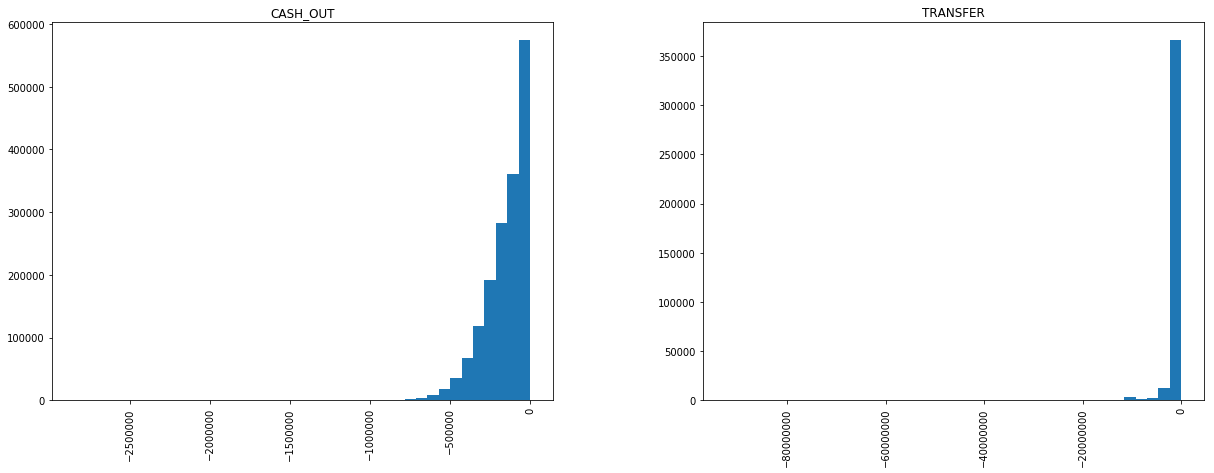

FRAUD


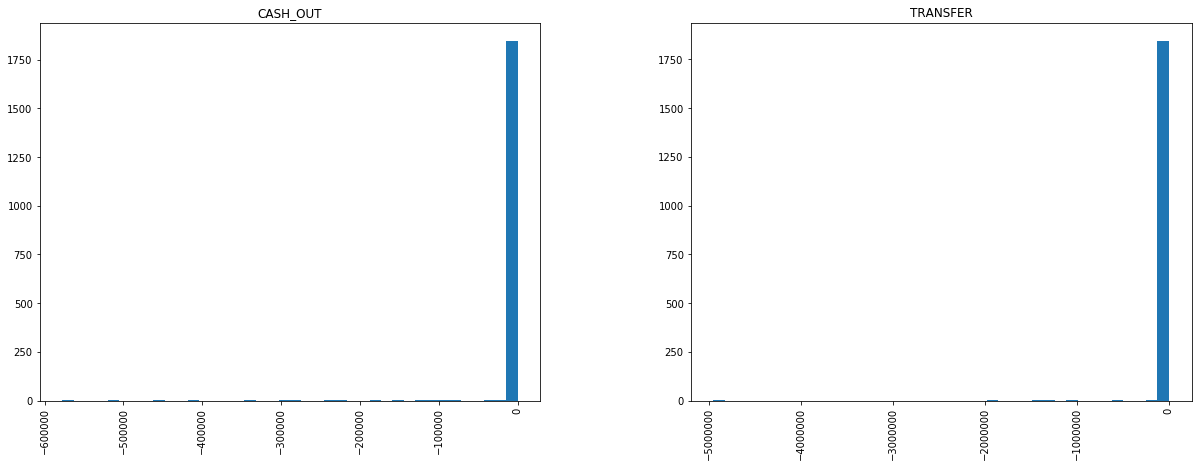

In [61]:
#### most frauds come from these 2 tran types with correct final orig balance

#### check distribution of difference of calculated to actual final balance of originator

data['recalc_org_fnlBlnce'] = np.where(data['type']=='CASH_IN',data['oldbalanceOrg'] + data['amount'],data['oldbalanceOrg'] - data['amount'])

data['diff_org_fnl_balance'] = data['recalc_org_fnlBlnce'] - data['newbalanceOrig']


Fraud_cshout_transfer = data.loc[(data['type'].isin(['CASH_OUT','TRANSFER']))]

print("NO FRAUD")
df = Fraud_cshout_transfer.loc[Fraud_cshout_transfer['isFraud']==0]['diff_org_fnl_balance']
df.hist(bins=40, figsize=(20, 7), sharex=False, sharey=False, by=Fraud_cshout_transfer['type'])
plt.ticklabel_format(style='plain')
plt.legend(prop={'size': 10})
plt.show()

print("FRAUD")
Fraud_cshout_transfer.loc[Fraud_cshout_transfer['isFraud']==1]['diff_org_fnl_balance'].hist(bins=40, figsize=(20, 7), sharex=False, sharey=False, by=Fraud_cshout_transfer['type'])
plt.ticklabel_format(style='plain')
plt.legend(prop={'size': 10})
plt.show()

In [62]:
data['dtl_recalc_newbalance_org'] = np.where(data['type'] == 'CASH_IN', np.ceil(data['oldbalanceOrg'] + data['amount'])
                                        ,np.ceil(data['oldbalanceOrg'] - data['amount']))
 

# missing data - not talking negative values  
# close dif -1<newbalanceOrig - recalc_newbalance_org<1  -> recalc_newbalance_org-1<newbalanceOrig< recalc_newbalance_org + 1      - rounding issue
# correct
# wrong

conditions = [ # are equal or recalc_newbalance_org-1<=newbalanceOrig<=recalc_newbalance_org+1 - weird roundings
    (data['dtl_recalc_newbalance_org'] == np.ceil(data['newbalanceOrig'])),
    ((data['newbalanceOrig'] <= np.ceil(data['dtl_recalc_newbalance_org'])+1)&(data['newbalanceOrig'] >= np.ceil(data['dtl_recalc_newbalance_org'])-1)),
    (((data['newbalanceOrig'] > np.ceil(data['dtl_recalc_newbalance_org'])+1)|(data['newbalanceOrig'] < np.ceil(data['dtl_recalc_newbalance_org'])-1)) & (np.ceil(data['newbalanceOrig']) == 0)),
    (((data['newbalanceOrig'] > np.ceil(data['dtl_recalc_newbalance_org'])+1)|(data['newbalanceOrig'] < np.ceil(data['dtl_recalc_newbalance_org'])-1)) & (np.ceil(data['newbalanceOrig']) != 0))
             ]
choices = ['correct - equals', 'close dif -> rounding issue', 'missing data - not talking negative values', 'wrong']
data['recalc_vs_df_newbalance_org'] = np.select(conditions, choices, default='missing')
display(data[['recalc_vs_df_newbalance_org','isFraud']].groupby(['recalc_vs_df_newbalance_org']).agg({'isFraud':['count','sum']}))

isFraud         
                                              count      sum
recalc_vs_df_newbalance_org                                 
close dif -> rounding issue                    2726    0.000
correct - equals                            2032504 3693.000
missing data - not talking negative values  2658276   29.000
wrong                                            65    3.000

In [63]:
display(data[['recalc_vs_df_newbalance_org','type','isFraud','amount','newbalanceOrig']].loc[data['type'].isin(['CASH_OUT','TRANSFER'])].groupby(['recalc_vs_df_newbalance_org', 'type']).agg({'isFraud':['count','sum']
                                                                                                                                                                     ,'amount':['min','max']
                                                                                                                                                                     ,'newbalanceOrig':['min','max']}))

isFraud           \
                                                       count      sum   
recalc_vs_df_newbalance_org                type                         
close dif -> rounding issue                CASH_OUT      152    0.000   
                                           TRANSFER       16    0.000   
correct - equals                           CASH_OUT   189001 1848.000   
                                           TRANSFER    17878 1845.000   
missing data - not talking negative values CASH_OUT  1478439   24.000   
                                           TRANSFER   371459    5.000   
wrong                                      CASH_OUT        9    0.000   
                                           TRANSFER        5    3.000   

                                                        amount               \
                                                           min          max   
recalc_vs_df_newbalance_org                type                               
close dif -> rounding issue                CASH_OUT      1.580   549566.400   
                                           TRANSFER   3081.280  1036805.050   
correct - equals                           CASH_OUT      0.000 10000000.000   
                                           TRANSFER      3.320 10000000.000   
missing data - not talking negative values CASH_OUT      2.050  2847566.620   
                                           TRANSFER      2.600 92445516.640   
wrong                                      CASH_OUT   2066.520   476641.920   
                                           TRANSFER 169106.970  4953893.080   

                                                    newbalanceOrig  \
                                                               min   
recalc_vs_df_newbalance_org                type                      
close dif -> rounding issue                CASH_OUT          0.000   
                                           TRANSFER      42034.000   
correct - equals                           CASH_OUT          0.000   
                                           TRANSFER          0.000   
missing data - not talking negative values CASH_OUT          0.000   
                                           TRANSFER          0.000   
wrong                                      CASH_OUT       2250.990   
                                           TRANSFER     222300.990   

                                                                  
                                                             max  
recalc_vs_df_newbalance_org                type                   
close dif -> rounding issue                CASH_OUT 13673792.010  
                                           TRANSFER  2709701.000  
correct - equals                           CASH_OUT 43686616.330  
                                           TRANSFER 27670038.080  
missing data - not talking negative values CASH_OUT        0.000  
                                           TRANSFER        0.000  
wrong                                      CASH_OUT   510342.990  
                                           TRANSFER  4953893.080

In [64]:
display(data[['recalc_vs_df_newbalance_org','type','ext_org_ind','ext_den_ind','isFraud']].loc[data['type'].isin(['CASH_OUT','TRANSFER'])].groupby(['recalc_vs_df_newbalance_org','type', 'ext_org_ind','ext_den_ind']).agg({'isFraud':['count','sum']}))

isFraud  \
                                                                               count   
recalc_vs_df_newbalance_org                type     ext_org_ind ext_den_ind            
close dif -> rounding issue                CASH_OUT C           C                152   
                                           TRANSFER C           C                 16   
correct - equals                           CASH_OUT C           C             189001   
                                           TRANSFER C           C              17878   
missing data - not talking negative values CASH_OUT C           C            1478439   
                                           TRANSFER C           C             371459   
wrong                                      CASH_OUT C           C                  9   
                                           TRANSFER C           C                  5   

                                                                                      
                                                                                 sum  
recalc_vs_df_newbalance_org                type     ext_org_ind ext_den_ind           
close dif -> rounding issue                CASH_OUT C           C              0.000  
                                           TRANSFER C           C              0.000  
correct - equals                           CASH_OUT C           C           1848.000  
                                           TRANSFER C           C           1845.000  
missing data - not talking negative values CASH_OUT C           C             24.000  
                                           TRANSFER C           C              5.000  
wrong                                      CASH_OUT C           C              0.000  
                                           TRANSFER C           C              3.000

## check the validity of Destination balances

In [70]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,name,destEntity_trxCnt,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
0,1,PAYMENT,9839.640,C1231006815,170136.000,160296.360,M1979787155,0.000,0.000,0.000,...,M1979787155,1,C,M,right value,160296.360,0.000,160297.000,correct - equals,0
1,1,PAYMENT,1864.280,C1666544295,21249.000,19384.720,M2044282225,0.000,0.000,0.000,...,M2044282225,1,C,M,right value,19384.720,0.000,19385.000,correct - equals,0
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,...,C553264065,39,C,C,right value,0.000,0.000,0.000,correct - equals,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,...,C38997010,38,C,C,right value,0.000,0.000,0.000,correct - equals,0
4,1,PAYMENT,11668.140,C2048537720,41554.000,29885.860,M1230701703,0.000,0.000,0.000,...,M1230701703,1,C,M,right value,29885.860,0.000,29886.000,correct - equals,0


In [81]:
display(data.groupby('type').agg({'isFraud':['count','sum']}))
display(data.loc[data['oldbalanceDest'] == data['newbalanceDest']].groupby('type').agg({'isFraud':['count','sum']}))
display(data.loc[(data['oldbalanceDest'] == data['newbalanceDest'] )&(data['newbalanceDest'] == 0)&(data['amount']!=0)].groupby('type').agg({'isFraud':['count','sum']}))

isFraud         
            count      sum
type                      
CASH_IN   1028902    0.000
CASH_OUT  1667601 1872.000
DEBIT       29203    0.000
PAYMENT   1578507    0.000
TRANSFER   389358 1853.000

isFraud         
            count      sum
type                      
CASH_IN    115636    0.000
CASH_OUT     1506    5.000
PAYMENT   1578507    0.000
TRANSFER     1929 1824.000

isFraud         
            count      sum
type                      
CASH_IN    115636    0.000
CASH_OUT     1503    2.000
PAYMENT   1578507    0.000
TRANSFER     1929 1824.000

### !!!! transfers with 0 destination balances before and after tend to be fraudulent!!!

NO FRAUD


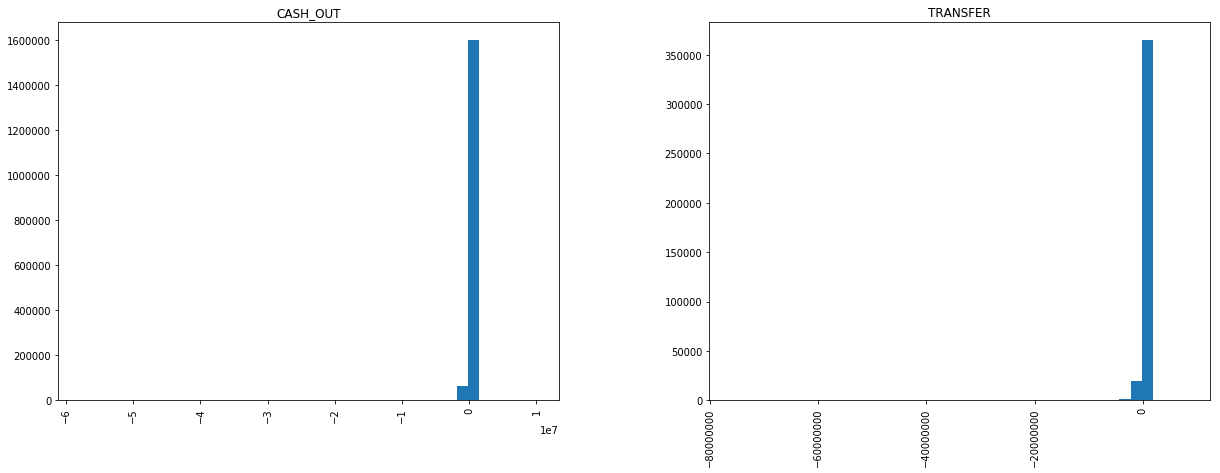

FRAUD


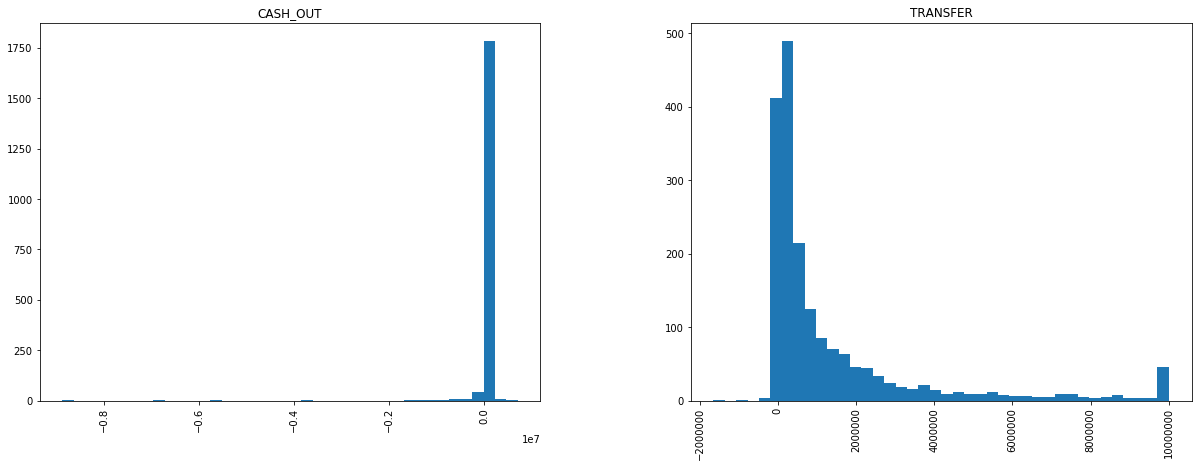

In [74]:
#### most frauds come from these 2 tran types with correct final orig balance

#### check distribution of difference of calculated to actual final balance of originator

data['recalc_dest_fnlBlnce'] = np.where(data['type']=='CASH_IN',data['oldbalanceDest'] - data['amount'],data['oldbalanceDest'] + data['amount'])

data['diff_dest_fnl_balance'] = data['recalc_dest_fnlBlnce'] - data['newbalanceDest']


Fraud_cshout_transfer = data.loc[(data['type'].isin(['CASH_OUT','TRANSFER']))]

print("NO FRAUD")
df = Fraud_cshout_transfer.loc[Fraud_cshout_transfer['isFraud']==0]['diff_dest_fnl_balance']
df.hist(bins=40, figsize=(20, 7), sharex=False, sharey=False, by=Fraud_cshout_transfer['type'])
plt.ticklabel_format(style='plain')
plt.legend(prop={'size': 10})
plt.show()

print("FRAUD")
Fraud_cshout_transfer.loc[Fraud_cshout_transfer['isFraud']==1]['diff_dest_fnl_balance'].hist(bins=40, figsize=(20, 7), sharex=False, sharey=False, by=Fraud_cshout_transfer['type'])
plt.ticklabel_format(style='plain')
plt.legend(prop={'size': 10})
plt.show()

In [75]:
data['dtl_recalc_newbalance_dest'] = np.where(data['type'] == 'CASH_IN', np.ceil(data['oldbalanceDest'] - data['amount'])
                                        ,np.ceil(data['oldbalanceDest'] + data['amount']))
 

# missing data - not talking negative values  
# close dif -1<newbalanceOrig - recalc_newbalance_org<1  -> recalc_newbalance_org-1<newbalanceOrig< recalc_newbalance_org + 1      - rounding issue
# correct
# wrong

conditions = [ # are equal or recalc_newbalance_org-1<=newbalanceOrig<=recalc_newbalance_org+1 - weird roundings
    (data['dtl_recalc_newbalance_dest'] == np.ceil(data['newbalanceOrig'])),
    ((data['newbalanceDest'] <= np.ceil(data['dtl_recalc_newbalance_dest'])+1)&(data['newbalanceDest'] >= np.ceil(data['dtl_recalc_newbalance_dest'])-1)),
    (((data['newbalanceDest'] > np.ceil(data['dtl_recalc_newbalance_dest'])+1)|(data['newbalanceDest'] < np.ceil(data['dtl_recalc_newbalance_dest'])-1)) & (np.ceil(data['newbalanceDest']) == 0)),
    (((data['newbalanceDest'] > np.ceil(data['dtl_recalc_newbalance_dest'])+1)|(data['newbalanceDest'] < np.ceil(data['dtl_recalc_newbalance_dest'])-1)) & (np.ceil(data['newbalanceDest']) != 0))
             ]
choices = ['correct - equals', 'close dif -> rounding issue', 'missing data - not talking negative values', 'wrong']
data['recalc_vs_df_newbalance_dest'] = np.select(conditions, choices, default='missing')
display(data[['recalc_vs_df_newbalance_dest','isFraud']].groupby(['recalc_vs_df_newbalance_dest']).agg({'isFraud':['count','sum']}))


display(data[['recalc_vs_df_newbalance_dest','type','isFraud','amount','newbalanceDest']].loc[data['type'].isin(['CASH_OUT','TRANSFER'])].groupby(['recalc_vs_df_newbalance_dest', 'type']).agg({'isFraud':['count','sum']
                                                                                                                                                                     ,'amount':['min','max']
                                                                                                                                                                     ,'newbalanceDest':['min','max']}))


display(data[['recalc_vs_df_newbalance_dest','type','ext_org_ind','ext_den_ind','isFraud']].loc[data['type'].isin(['CASH_OUT','TRANSFER'])].groupby(['recalc_vs_df_newbalance_dest','type', 'ext_org_ind','ext_den_ind']).agg({'isFraud':['count','sum']}))

isFraud         
                                              count      sum
recalc_vs_df_newbalance_dest                                
close dif -> rounding issue                 2570361 1739.000
correct - equals                                 19    5.000
missing data - not talking negative values  1791679 1837.000
wrong                                        331512  144.000

isFraud           \
                                                       count      sum   
recalc_vs_df_newbalance_dest               type                         
close dif -> rounding issue                CASH_OUT  1468451 1736.000   
                                           TRANSFER   336736    3.000   
correct - equals                           CASH_OUT        3    2.000   
                                           TRANSFER        3    3.000   
missing data - not talking negative values CASH_OUT    10812   16.000   
                                           TRANSFER     2874 1821.000   
wrong                                      CASH_OUT   188335  118.000   
                                           TRANSFER    49745   26.000   

                                                        amount               \
                                                           min          max   
recalc_vs_df_newbalance_dest               type                               
close dif -> rounding issue                CASH_OUT      0.000 10000000.000   
                                           TRANSFER      2.600 92445516.640   
correct - equals                           CASH_OUT      0.000    61382.460   
                                           TRANSFER 536624.410  4953893.080   
missing data - not talking negative values CASH_OUT     12.340   841651.430   
                                           TRANSFER    119.000 10000000.000   
wrong                                      CASH_OUT      1.580 10000000.000   
                                           TRANSFER     74.130 64234448.190   

                                                    newbalanceDest  \
                                                               min   
recalc_vs_df_newbalance_dest               type                      
close dif -> rounding issue                CASH_OUT          0.000   
                                           TRANSFER         18.560   
correct - equals                           CASH_OUT          0.000   
                                           TRANSFER          0.000   
missing data - not talking negative values CASH_OUT          0.000   
                                           TRANSFER          0.000   
wrong                                      CASH_OUT         12.100   
                                           TRANSFER        322.490   

                                                                   
                                                              max  
recalc_vs_df_newbalance_dest               type                    
close dif -> rounding issue                CASH_OUT 311492902.800  
                                           TRANSFER 355553416.300  
correct - equals                           CASH_OUT     64261.460  
                                           TRANSFER         0.000  
missing data - not talking negative values CASH_OUT         0.000  
                                           TRANSFER         0.000  
wrong                                      CASH_OUT 194661381.760  
                                           TRANSFER 355553416.300

isFraud  \
                                                                               count   
recalc_vs_df_newbalance_dest               type     ext_org_ind ext_den_ind            
close dif -> rounding issue                CASH_OUT C           C            1468451   
                                           TRANSFER C           C             336736   
correct - equals                           CASH_OUT C           C                  3   
                                           TRANSFER C           C                  3   
missing data - not talking negative values CASH_OUT C           C              10812   
                                           TRANSFER C           C               2874   
wrong                                      CASH_OUT C           C             188335   
                                           TRANSFER C           C              49745   

                                                                                      
                                                                                 sum  
recalc_vs_df_newbalance_dest               type     ext_org_ind ext_den_ind           
close dif -> rounding issue                CASH_OUT C           C           1736.000  
                                           TRANSFER C           C              3.000  
correct - equals                           CASH_OUT C           C              2.000  
                                           TRANSFER C           C              3.000  
missing data - not talking negative values CASH_OUT C           C             16.000  
                                           TRANSFER C           C           1821.000  
wrong                                      CASH_OUT C           C            118.000  
                                           TRANSFER C           C             26.000

In [76]:
### in combo with the orig balance

display(data[['recalc_vs_df_newbalance_org','recalc_vs_df_newbalance_dest','type','isFraud']].loc[data['type'].isin(['CASH_OUT','TRANSFER'])].groupby(['recalc_vs_df_newbalance_org','recalc_vs_df_newbalance_dest','type']).agg({'isFraud':['count','sum']}))

isFraud  \
                                                                                                  count   
recalc_vs_df_newbalance_org                recalc_vs_df_newbalance_dest               type                
close dif -> rounding issue                close dif -> rounding issue                CASH_OUT      124   
                                                                                      TRANSFER       13   
                                           missing data - not talking negative values CASH_OUT        1   
                                           wrong                                      CASH_OUT       27   
                                                                                      TRANSFER        3   
correct - equals                           close dif -> rounding issue                CASH_OUT   167203   
                                                                                      TRANSFER    14041   
                                           correct - equals                           CASH_OUT        3   
                                           missing data - not talking negative values CASH_OUT     2103   
                                                                                      TRANSFER     1959   
                                           wrong                                      CASH_OUT    19692   
                                                                                      TRANSFER     1878   
missing data - not talking negative values close dif -> rounding issue                CASH_OUT  1301122   
                                                                                      TRANSFER   322681   
                                           missing data - not talking negative values CASH_OUT     8706   
                                                                                      TRANSFER      915   
                                           wrong                                      CASH_OUT   168611   
                                                                                      TRANSFER    47863   
wrong                                      close dif -> rounding issue                CASH_OUT        2   
                                                                                      TRANSFER        1   
                                           correct - equals                           TRANSFER        3   
                                           missing data - not talking negative values CASH_OUT        2   
                                           wrong                                      CASH_OUT        5   
                                                                                      TRANSFER        1   

                                                                                                         
                                                                                                    sum  
recalc_vs_df_newbalance_org                recalc_vs_df_newbalance_dest               type               
close dif -> rounding issue                close dif -> rounding issue                CASH_OUT    0.000  
                                                                                      TRANSFER    0.000  
                                           missing data - not talking negative values CASH_OUT    0.000  
                                           wrong                                      CASH_OUT    0.000  
                                                                                      TRANSFER    0.000  
correct - equals                           close dif -> rounding issue                CASH_OUT 1715.000  
                                                                                      TRANSFER    0.000  
                                           correct - equals                           CASH_OUT    2.000  
                                        

## check amount (zero values + scatter plot + candle plot)

In [98]:
print(" amount == 0")
display(data.loc[data['amount'] == 0].agg({'amount':['count','sum']}))

print("""\nadding weird rounds to the 0 values (data['amount'] >= -1) & (data['amount'] <= 1)""")
display(data.loc[(data['amount'] >= -1) & (data['amount'] <= 1)].agg({'amount':['count','sum']}))

print("""\namount negative values""")
display(data.loc[(data['amount'] <0) ].agg({'amount':['count','sum']}))

 amount == 0


,amount
count,3.000
sum,0.000



adding weird rounds to the 0 values (data['amount'] >= -1) & (data['amount'] <= 1)


,amount
count,93.000
sum,42.530



amount negative values


,amount
count,0.000
sum,0.000


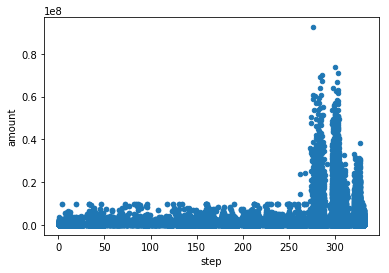

In [99]:
data.plot.scatter(x='step',y='amount')

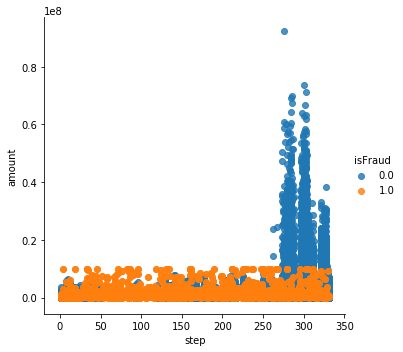

In [100]:
sns.lmplot(x='step',y='amount', data=data, hue='isFraud', fit_reg=False)

### 5)check if isFraud is correclty as per the definition

In [65]:
# check if isFraud is correclty as per the definition:
# The business model aims to control massive transfers from one account to another and flags illegal attempts. 
 #                An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


data['sim_isFraud'] = np.where(data['amount']>200000, 1,0)

display(data[['type','sim_isFraud','isFraud']].groupby(['type']).agg({'sim_isFraud':['count','sum'],'isFraud':['count','sum']}))
display(data[['sim_isFraud','isFraud','type']].groupby(['sim_isFraud','isFraud']).count())

display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='CASH_IN')].head(2))
display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='CASH_OUT')].head(2))
display(data.loc[(data['sim_isFraud'] == 1) & (data['isFraud'] == 0) & (data['type']=='TRANSFER')].head(2))


# nope it's not, something else is happening as well

sim_isFraud          isFraud         
               count     sum    count      sum
type                                          
CASH_IN      1028902  348455  1028902    0.000
CASH_OUT     1667601  593308  1667601 1872.000
DEBIT          29203      18    29203    0.000
PAYMENT      1578507       0  1578507    0.000
TRANSFER      389358  298142   389358 1853.000

type
sim_isFraud isFraud         
0           0.000    3452353
            1.000       1295
1           0.000    1237493
            1.000       2430

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,name,destEntity_trxCnt,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
390,1,CASH_IN,228451.890,C1614133563,143236.260,371688.150,C2083562754,719678.380,1186556.810,0.000,...,C2083562754,100,C,C,right value,371688.150,0.000,371689.000,correct - equals,1
392,1,CASH_IN,232953.640,C1037163664,407590.650,640544.280,C33524623,1172672.270,1517262.160,0.000,...,C33524623,77,C,C,right value,640544.290,0.010,640545.000,correct - equals,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,name,destEntity_trxCnt,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
15,1,CASH_OUT,229133.940,C905080434,15325.000,0.000,C476402209,5083.000,51513.440,0.000,...,C476402209,34,C,C,wrong value,-213808.940,-213808.940,-213808.000,missing data - not talking negative values,1
112,1,CASH_OUT,212228.350,C1896074070,0.000,0.000,C401424608,429747.000,1178808.140,0.000,...,C401424608,39,C,C,wrong value,-212228.350,-212228.350,-212228.000,missing data - not talking negative values,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,name,destEntity_trxCnt,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
19,1,TRANSFER,215310.300,C1670993182,705.000,0.000,C1100439041,22425.000,0.000,0.000,...,C1100439041,46,C,C,wrong value,-214605.300,-214605.300,-214605.000,missing data - not talking negative values,1
24,1,TRANSFER,311685.890,C1984094095,10835.000,0.000,C932583850,6267.000,2719172.890,0.000,...,C932583850,78,C,C,wrong value,-300850.890,-300850.890,-300850.000,missing data - not talking negative values,1


### plot step (time) vs fraud for the 2 tran types

In [66]:
### plot step (time) vs fraud for the 2 tran types

df = data.loc[data['type'].isin(['CASH_OUT','TRANSFER'])]

df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,name,destEntity_trxCnt,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
2,1,TRANSFER,181.000,C1305486145,181.000,0.000,C553264065,0.000,0.000,1.000,...,C553264065,39,C,C,right value,0.000,0.000,0.000,correct - equals,0
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,...,C38997010,38,C,C,right value,0.000,0.000,0.000,correct - equals,0
15,1,CASH_OUT,229133.940,C905080434,15325.000,0.000,C476402209,5083.000,51513.440,0.000,...,C476402209,34,C,C,wrong value,-213808.940,-213808.940,-213808.000,missing data - not talking negative values,1
19,1,TRANSFER,215310.300,C1670993182,705.000,0.000,C1100439041,22425.000,0.000,0.000,...,C1100439041,46,C,C,wrong value,-214605.300,-214605.300,-214605.000,missing data - not talking negative values,1
24,1,TRANSFER,311685.890,C1984094095,10835.000,0.000,C932583850,6267.000,2719172.890,0.000,...,C932583850,78,C,C,wrong value,-300850.890,-300850.890,-300850.000,missing data - not talking negative values,1



                                                         VOLUME of trx (count)



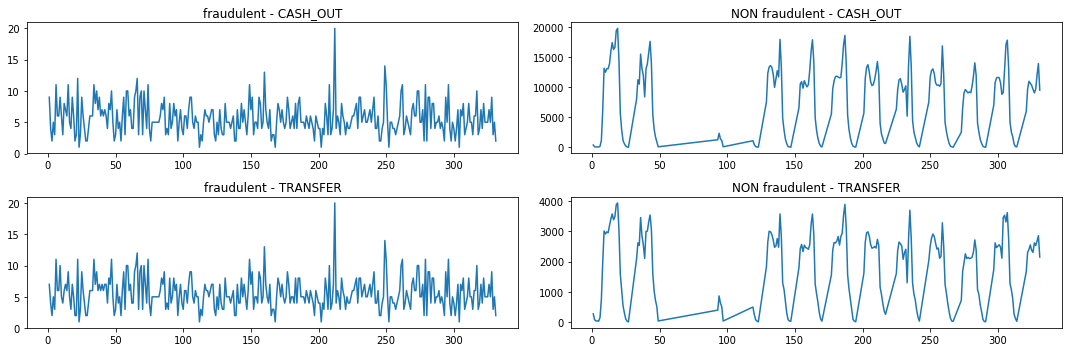

In [67]:
# count of fraud vs non-fraud trx per time for both tran types

df_agg = df.groupby(['step','type','isFraud'])['isFraud'].count().reset_index(name="count")
df_agg.head(10)

print("\n                                                         VOLUME of trx (count)\n")
fig, ax = plt.subplots(2,2,figsize=(15,5))
ax[0,0].plot(df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==1),['step']], df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==1),["count"]])
ax[0,0].set_title("fraudulent - CASH_OUT")
ax[1,0].plot(df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==1),['step']], df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==1),["count"]])
ax[1,0].set_title("fraudulent - TRANSFER")
ax[0,1].plot(df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==0),['step']], df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==0),["count"]])
ax[0,1].set_title("NON fraudulent - CASH_OUT")
ax[1,1].plot(df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==0),['step']], df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==0),["count"]])
ax[1,1].set_title("NON fraudulent - TRANSFER")
fig.tight_layout()
plt.legend()
plt.show()


                                                         VALUE of trx (sum)



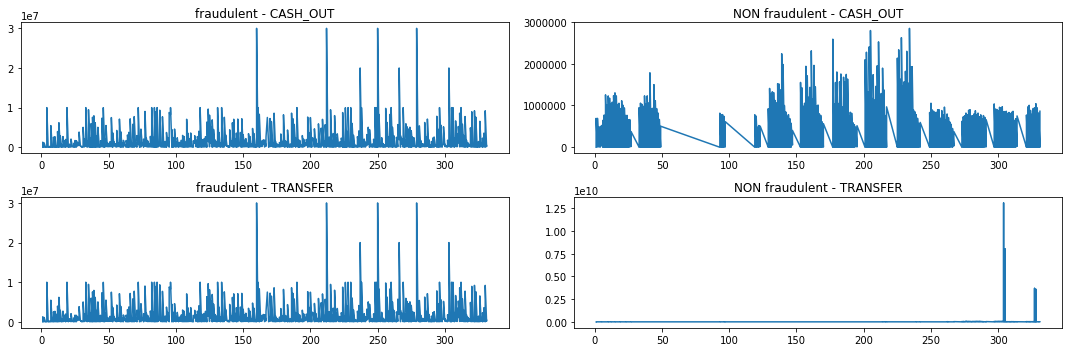

In [68]:
# count of fraud vs non-fraud trx per time for both tran types

df_agg = df.groupby(['step','type','isFraud','amount'])['amount'].sum().reset_index(name="sum")
df_agg.head(10)

print("\n                                                         VALUE of trx (sum)\n")
fig, ax = plt.subplots(2,2,figsize=(15,5))
ax[0,0].plot(df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==1),['step']], df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==1),["sum"]])
ax[0,0].set_title("fraudulent - CASH_OUT")
ax[1,0].plot(df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==1),['step']], df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==1),["sum"]])
ax[1,0].set_title("fraudulent - TRANSFER")
ax[0,1].plot(df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==0),['step']], df_agg.loc[(df_agg['type']=='CASH_OUT')&(df_agg['isFraud']==0),["sum"]])
ax[0,1].set_title("NON fraudulent - CASH_OUT")
ax[1,1].plot(df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==0),['step']], df_agg.loc[(df_agg['type']=='TRANSFER')&(df_agg['isFraud']==0),["sum"]])
ax[1,1].set_title("NON fraudulent - TRANSFER")
fig.tight_layout()
plt.legend()
plt.show()

### credit trans the originator takes money (increase balance of originator)
### debit trans the originator gives money (decrease balance of originator)

orig entity is originator x amoount of transactions

orig entity is destination y amount of trx

(possible douplication ie a trx counted in both org and den if same entity id in both fields) - NONE!!

In [23]:
# how many records have common originator - destination

display(data.loc[data['nameOrig'] == data['nameDest']].count())

display(data.loc[data['nameOrig'] == data['nameDest']].groupby('isFraud').count())

step                                0
type                                0
amount                              0
nameOrig                            0
oldbalanceOrg                       0
newbalanceOrig                      0
nameDest                            0
oldbalanceDest                      0
newbalanceDest                      0
isFraud                             0
isFlaggedFraud                      0
ext_org_ind                         0
ext_den_ind                         0
org_wthdrawls_fnlBlnce_right_flg    0
recalc_org_fnlBlnce                 0
diff_org_fnl_balance                0
dtl_recalc_newbalance_org           0
recalc_vs_df_newbalance_org         0
sim_isFraud                         0
dtype: int64

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,ext_org_ind,ext_den_ind,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud
isFraud,,,,,,,,,,,,,,,,,,


In [24]:
# orig entities in destination

display(data.loc[data['nameOrig'].isin(data['nameDest']),['nameOrig']].nunique())

# dest entities in destination

display(data.loc[data['nameDest'].isin(data['nameOrig']),['nameDest']].nunique())

nameOrig    999
dtype: int64

nameDest    999
dtype: int64

In [37]:
# orig entity is originator x amoount of transactions

nameOrig_freq = data.groupby(['nameOrig'])['nameOrig'].count().reset_index(name="origEntity_trxCnt_origPos")
# fill na with 0 as it indicates no transactions
nameOrig_freq.fillna(0)
# merge to dataset
data = data.merge(nameOrig_freq,how = 'left', on = 'nameOrig')
# rename to prepare for the total count per customer
nameOrig_freq.rename(columns={'nameOrig':'name', 'origEntity_trxCnt_origPos':'origEntity_trxCnt'},inplace = True)


nameDest_freq = data.groupby(['nameDest'])['nameDest'].count().reset_index(name="origEntity_trxCnt_destPos")
# fill na with 0 as it indicates no transactions
nameDest_freq.fillna(0)
# merge to dataset
data = data.merge(nameDest_freq,how = 'left',left_on = 'nameOrig', right_on = 'nameDest').drop(columns= ['nameDest_y']).rename(columns={'nameDest_x':'nameDest'})
# rename to prepare for the total count per customer
nameDest_freq.rename(columns={'nameDest':'name', 'origEntity_trxCnt_destPos':'origEntity_trxCnt'},inplace = True)


all_Origcust_freq = nameOrig_freq.append(nameDest_freq)
all_Origcust_freq = all_Origcust_freq.groupby('name')['origEntity_trxCnt'].sum().reset_index(name="origEntity_trxCnt")
# merge to dataset
data = data.merge(all_Origcust_freq,how = 'left', left_on = 'nameOrig', right_on = 'name').drop(columns= ['name'])




In [46]:
# Destination entity is destination for x amoount of transactions

nameDest_freq = data.groupby(['nameDest'])['nameDest'].count().reset_index(name="destEntity_trxCnt_origPos")
# fill na with 0 as it indicates no transactions
nameDest_freq.fillna(0)
# merge to dataset
data = data.merge(nameDest_freq,how = 'left', on = 'nameDest')
# rename to prepare for the total count per customer
nameDest_freq.rename(columns={'nameDest':'name', 'destEntity_trxCnt_origPos':'destEntity_trxCnt'},inplace = True)

# print("dest entitiy in orig pos")
# display(nameDest_freq.loc[nameDest_freq['name']=='C1626852381'])
# display(data.sort_values(by=['step']).loc[(data['nameDest'] == 'C1626852381') | (data['nameOrig'] == 'C1626852381')])

nameOrig_freq = data.groupby(['nameOrig'])['nameOrig'].count().reset_index(name="destEntity_trxCnt_destPos")
# fill na with 0 as it indicates no transactions
nameOrig_freq.fillna(0)
# merge to dataset
data = data.merge(nameOrig_freq,how = 'left',left_on = 'nameDest', right_on = 'nameOrig').drop(columns= ['nameOrig_y']).rename(columns={'nameOrig_x':'nameOrig'})
# rename to prepare for the total count per customer
nameOrig_freq.rename(columns={'nameOrig':'name', 'destEntity_trxCnt_destPos':'destEntity_trxCnt'},inplace = True)


# print("dest entitiy in dest pos")
# display(nameOrig_freq.loc[nameOrig_freq['name']=='C1626852381'])
# display(data.sort_values(by=['step']).loc[(data['nameDest'] == 'C1626852381') | (data['nameOrig'] == 'C1626852381')])

all_Destcust_freq = nameOrig_freq.append(nameDest_freq)
all_Destcust_freq = all_Destcust_freq.groupby('name')['destEntity_trxCnt'].sum().reset_index(name="destEntity_trxCnt")
# merge to dataset
data = data.merge(all_Destcust_freq,how = 'left', left_on = 'nameDest', right_on = 'name').drop(columns= ['name'])
# print("final")
# data.sort_values(by=['step']).loc[(data['nameDest'] == 'C1626852381') | (data['nameOrig'] == 'C1626852381')]

dest entitiy in orig pos


,name,destEntity_trxCnt
136564,C1626852381,9


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos
571,1,PAYMENT,3316.210,C1626852381,0.000,0.000,M300604602,0.000,0.000,0.000,0.000,1,9.000,10,1,nan
1792586,162,CASH_OUT,3740.040,C1454676819,5086.000,1345.960,C1626852381,0.000,3740.040,0.000,0.000,1,nan,1,9,1.000
1914278,166,CASH_IN,55560.910,C292773454,16900.000,72460.910,C1626852381,3740.040,0.000,0.000,0.000,1,nan,1,9,1.000
2057389,181,CASH_OUT,324505.420,C1475918760,1433.000,0.000,C1626852381,0.000,324505.420,0.000,0.000,1,nan,1,9,1.000
2494140,204,CASH_IN,217705.570,C1489616155,3502627.480,3720333.050,C1626852381,324505.420,273813.800,0.000,0.000,1,nan,1,9,1.000
2524122,205,CASH_OUT,167013.950,C1549778347,372.000,0.000,C1626852381,106799.850,273813.800,0.000,0.000,1,nan,1,9,1.000
2701619,211,CASH_OUT,111429.310,C773947921,1288.000,0.000,C1626852381,273813.800,423809.390,0.000,0.000,1,nan,1,9,1.000
2756243,212,CASH_OUT,323573.820,C208794750,0.000,0.000,C1626852381,423809.390,747383.210,0.000,0.000,1,nan,1,9,1.000
2731411,212,CASH_OUT,38566.280,C858974359,0.000,0.000,C1626852381,385243.110,423809.390,0.000,0.000,1,nan,1,9,1.000
4107691,302,CASH_IN,15473.330,C1281216362,6718466.930,6733940.270,C1626852381,747383.210,731909.880,0.000,0.000,1,nan,1,9,1.000


dest entitiy in dest pos


,name,destEntity_trxCnt
1520101,C1626852381,1


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos
571,1,PAYMENT,3316.210,C1626852381,0.000,0.000,M300604602,0.000,0.000,0.000,0.000,1,9.000,10,1,nan
1792586,162,CASH_OUT,3740.040,C1454676819,5086.000,1345.960,C1626852381,0.000,3740.040,0.000,0.000,1,nan,1,9,1.000
1914278,166,CASH_IN,55560.910,C292773454,16900.000,72460.910,C1626852381,3740.040,0.000,0.000,0.000,1,nan,1,9,1.000
2057389,181,CASH_OUT,324505.420,C1475918760,1433.000,0.000,C1626852381,0.000,324505.420,0.000,0.000,1,nan,1,9,1.000
2494140,204,CASH_IN,217705.570,C1489616155,3502627.480,3720333.050,C1626852381,324505.420,273813.800,0.000,0.000,1,nan,1,9,1.000
2524122,205,CASH_OUT,167013.950,C1549778347,372.000,0.000,C1626852381,106799.850,273813.800,0.000,0.000,1,nan,1,9,1.000
2701619,211,CASH_OUT,111429.310,C773947921,1288.000,0.000,C1626852381,273813.800,423809.390,0.000,0.000,1,nan,1,9,1.000
2756243,212,CASH_OUT,323573.820,C208794750,0.000,0.000,C1626852381,423809.390,747383.210,0.000,0.000,1,nan,1,9,1.000
2731411,212,CASH_OUT,38566.280,C858974359,0.000,0.000,C1626852381,385243.110,423809.390,0.000,0.000,1,nan,1,9,1.000
4107691,302,CASH_IN,15473.330,C1281216362,6718466.930,6733940.270,C1626852381,747383.210,731909.880,0.000,0.000,1,nan,1,9,1.000


final


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos,name,destEntity_trxCnt
571,1,PAYMENT,3316.210,C1626852381,0.000,0.000,M300604602,0.000,0.000,0.000,0.000,1,9.000,10,1,nan,M300604602,1
1792586,162,CASH_OUT,3740.040,C1454676819,5086.000,1345.960,C1626852381,0.000,3740.040,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
1914278,166,CASH_IN,55560.910,C292773454,16900.000,72460.910,C1626852381,3740.040,0.000,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2057389,181,CASH_OUT,324505.420,C1475918760,1433.000,0.000,C1626852381,0.000,324505.420,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2494140,204,CASH_IN,217705.570,C1489616155,3502627.480,3720333.050,C1626852381,324505.420,273813.800,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2524122,205,CASH_OUT,167013.950,C1549778347,372.000,0.000,C1626852381,106799.850,273813.800,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2701619,211,CASH_OUT,111429.310,C773947921,1288.000,0.000,C1626852381,273813.800,423809.390,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2756243,212,CASH_OUT,323573.820,C208794750,0.000,0.000,C1626852381,423809.390,747383.210,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
2731411,212,CASH_OUT,38566.280,C858974359,0.000,0.000,C1626852381,385243.110,423809.390,0.000,0.000,1,nan,1,9,1.000,C1626852381,10
4107691,302,CASH_IN,15473.330,C1281216362,6718466.930,6733940.270,C1626852381,747383.210,731909.880,0.000,0.000,1,nan,1,9,1.000,C1626852381,10


In [47]:
display(describe(data[['origEntity_trxCnt_origPos','origEntity_trxCnt_destPos','origEntity_trxCnt','destEntity_trxCnt_origPos','destEntity_trxCnt_destPos','destEntity_trxCnt']],['skew','sum']))

display(describe(data.loc[data['isFraud']==1,['origEntity_trxCnt_origPos','origEntity_trxCnt_destPos','origEntity_trxCnt','destEntity_trxCnt_origPos','destEntity_trxCnt_destPos','destEntity_trxCnt']],['skew','sum']))

,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos,destEntity_trxCnt
count,4693572.000,1001.000,4693572.000,4693572.000,7444.000,4693572.000
mean,1.002,7.461,1.004,11.116,1.003,11.118
std,0.047,7.971,0.166,12.178,0.057,12.179
min,1.000,1.000,1.000,1.000,1.000,1.000
25%,1.000,2.000,1.000,1.000,1.000,1.000
50%,1.000,5.000,1.000,7.000,1.000,7.000
75%,1.000,10.000,1.000,17.000,1.000,17.000
max,3.000,56.000,57.000,108.000,2.000,108.000
skew,21.365,2.180,137.013,1.462,17.530,1.461
sum,4703894.000,7468.000,4711362.000,52175118.000,7468.000,52182586.000


,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,origEntity_trxCnt,destEntity_trxCnt_origPos,destEntity_trxCnt_destPos,destEntity_trxCnt
count,3725.000,0.000,3725.000,3725.000,6.000,3725.000
mean,1.002,nan,1.002,10.794,1.000,10.796
std,0.046,nan,0.046,10.514,0.000,10.513
min,1.000,nan,1.000,1.000,1.000,1.000
25%,1.000,nan,1.000,3.000,1.000,3.000
50%,1.000,nan,1.000,8.000,1.000,8.000
75%,1.000,nan,1.000,15.000,1.000,15.000
max,2.000,nan,2.000,89.000,1.000,89.000
skew,21.517,nan,21.517,1.875,0.000,1.875
sum,3733.000,0.000,3733.000,40209.000,6.000,40215.000


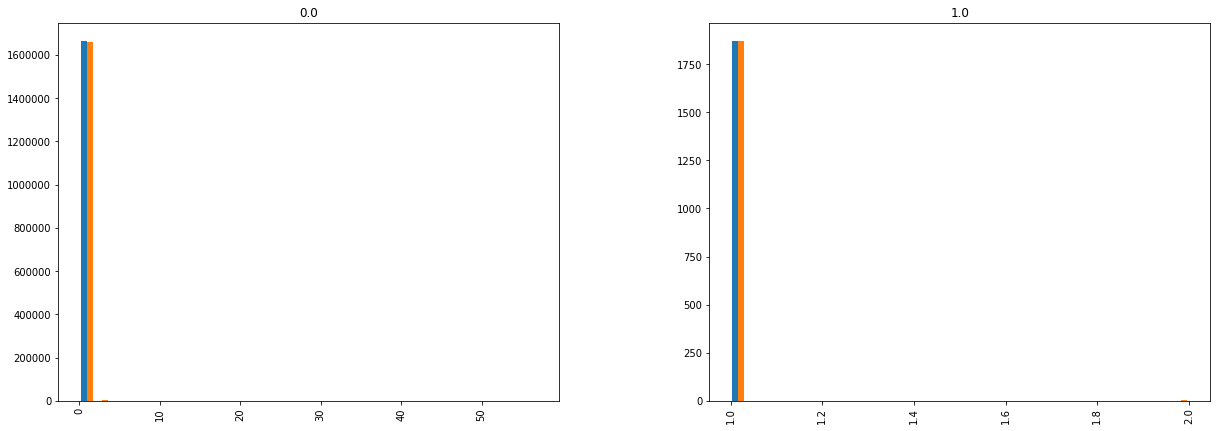

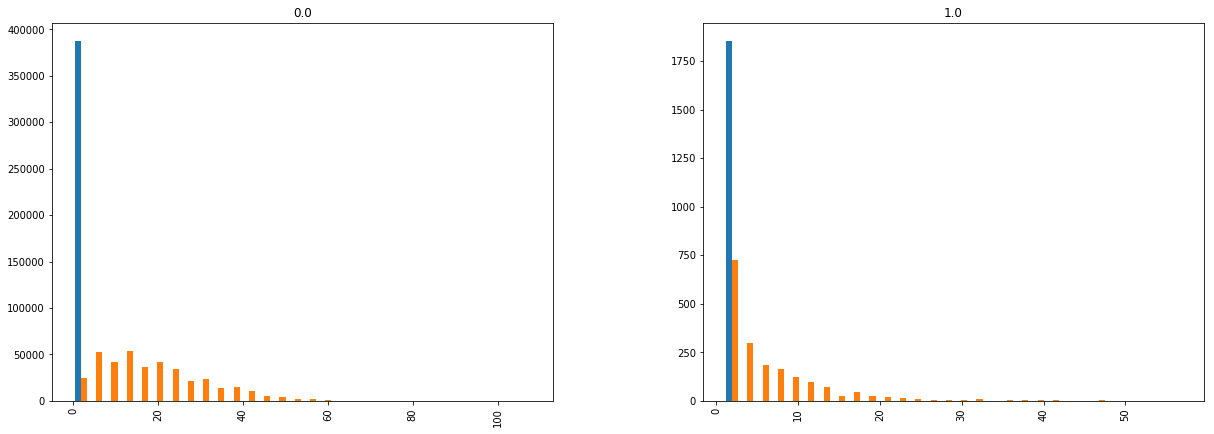

In [49]:
data.loc[data['type'].isin(['CASH_OUT']),['isFraud','origEntity_trxCnt']].hist(bins=30, figsize=(20, 7), sharex=False, sharey=False, by=data['isFraud'])
plt.show()

data.loc[data['type'].isin(['TRANSFER']),['isFraud','destEntity_trxCnt']].hist(bins=30, figsize=(20, 7), sharex=False, sharey=False, by=data['isFraud'])
plt.show()

In [ ]:
dp frauds come from orig-den that have no tohe

In [52]:
data.loc[data['type']=='CASH_OUT'].groupby(['type','origEntity_trxCnt','destEntity_trxCnt']).agg({'isFraud':['count','sum']})

isFraud       
                                               count    sum
type     origEntity_trxCnt destEntity_trxCnt               
CASH_OUT 1                 1                   40881 50.000
                           2                   58355 74.000
                           3                   67817 78.000
                           4                   71605 94.000
                           5                   73179 76.000
                           6                   73425 94.000
                           7                   72866 88.000
                           8                   71857 79.000
                           9                   68586 70.000
                           10                  66120 63.000
                           11                  63582 64.000
                           12                  60823 76.000
                           13                  58696 66.000
                           14                  54466 67.000
                           15                  52875 71.000
                           16                  50050 61.000
                           17                  45835 54.000
                           18                  44080 63.000
                           19                  40204 59.000
                           20                  40251 53.000
                           21                  35916 45.000
                           22                  33563 45.000
                           23                  33026 42.000
                           24                  29809 28.000
                           25                  27693 24.000
                           26                  27061 28.000
                           27                  25127 30.000
                           28                  23687 24.000
                           29                  22046 19.000
                           30                  20336 18.000
...                                              ...    ...
         22                6                       1  0.000
                           9                       1  0.000
                           30                      1  0.000
         23                17                      1  0.000
                           25                      1  0.000
                           34                      1  0.000
         24                5                       1  0.000
                           24                      1  0.000
                           31                      1  0.000
         25                4                       1  0.000
                           16                      1  0.000
                           20                      1  0.000
                           21                      1  0.000
         27                10                      1  0.000
                           11                      1  0.000
         28                17                      1  0.000
         29                5                       1  0.000
                           12                      1  0.000
                           14                      1  0.000
         31                2                       1  0.000
         32                2                       1  0.000
                           3                       1  0.000
         33                12                      1  0.000
         35                3                       1  0.000
                           18                      1  0.000
         38                7                       1  0.000
         41                12                      1  0.000
         47                17                      1  0.000
         52                20                      1  0.000
         57                34                      1  0.000

[389 rows x 2 columns]

In [69]:
data.loc[data['type']=='TRANSFER'].groupby(['type','origEntity_trxCnt','destEntity_trxCnt']).agg({'isFraud':['count','sum']})

isFraud        
                                               count     sum
type     origEntity_trxCnt destEntity_trxCnt                
TRANSFER 1                 1                    5869 462.000
                           2                    8801 260.000
                           3                   10996 147.000
                           4                   12366 148.000
                           5                   12954  99.000
                           6                   13683  83.000
                           7                   13886  92.000
                           8                   13984  70.000
                           9                   13975  65.000
                           10                  13967  59.000
                           11                  13969  63.000
                           12                  13633  36.000
                           13                  13606  43.000
                           14                  12619  31.000
                           15                  12638  24.000
                           16                  12105  26.000
                           17                  11488  19.000
                           18                  11224  14.000
                           19                  10536  12.000
                           20                  10396  13.000
                           21                   9659   8.000
                           22                   8974   9.000
                           23                   9211   5.000
                           24                   8090   4.000
                           25                   7650   5.000
                           26                   7602   1.000
                           27                   7033   2.000
                           28                   6952   6.000
                           29                   6430   3.000
                           30                   6025   2.000
...                                              ...     ...
         7                 17                      1   0.000
                           25                      1   0.000
                           42                      1   0.000
         8                 9                       1   0.000
                           12                      1   0.000
                           44                      1   0.000
         9                 9                       1   0.000
         10                4                       1   0.000
                           9                       1   0.000
                           37                      1   0.000
         11                15                      2   0.000
                           26                      1   0.000
                           29                      1   0.000
                           37                      1   0.000
         12                7                       1   0.000
                           19                      1   0.000
         13                10                      1   0.000
                           14                      1   0.000
         14                10                      1   0.000
                           25                      1   0.000
                           46                      1   0.000
         15                12                      1   0.000
         16                11                      1   0.000
         18                18                      1   0.000
                           34                      1   0.000
         21                30                      1   0.000
         26                10                      1   0.000
         27                16                      1   0.000
         30                10                      1   0.000
         52                10                      1   0.000

[218 rows x 2 columns]

### check if fraudulent trans occure on repetive Orig customers

In [86]:
all_frauds_orig = data.loc[data['isFraud']==1].groupby('nameOrig').agg({'isFraud':['count','sum']})
all_frauds_orig

,name,type,fraudCnt
0,C1000086512,CASH_OUT,1
1,C1000331499,TRANSFER,1
2,C1000513158,TRANSFER,1
3,C1000937208,TRANSFER,1
4,C1002446735,CASH_OUT,1
,name,type,fraudCnt


,name,type,fraudCnt
0,C1000039615,TRANSFER,1
1,C1000855680,TRANSFER,1
2,C1002031672,TRANSFER,1
3,C1002183297,TRANSFER,1
4,C1002469873,CASH_OUT,1
,name,type,fraudCnt
30,C1013511446,CASH_OUT,2
114,C105660024,CASH_OUT,2
702,C1399829166,CASH_OUT,2
886,C1497532505,CASH_OUT,2


,name,type,fraudCnt
0,C1000039615,TRANSFER,1
1,C1000086512,CASH_OUT,1
2,C1000331499,TRANSFER,1
3,C1000513158,TRANSFER,1
4,C1000855680,TRANSFER,1
,name,type,fraudCnt
53,C1013511446,CASH_OUT,2
232,C105660024,CASH_OUT,2
1443,C1399829166,CASH_OUT,2
1848,C1497532505,CASH_OUT,2


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fba2b2ec7f0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7fba2b241940>], dtype=object)

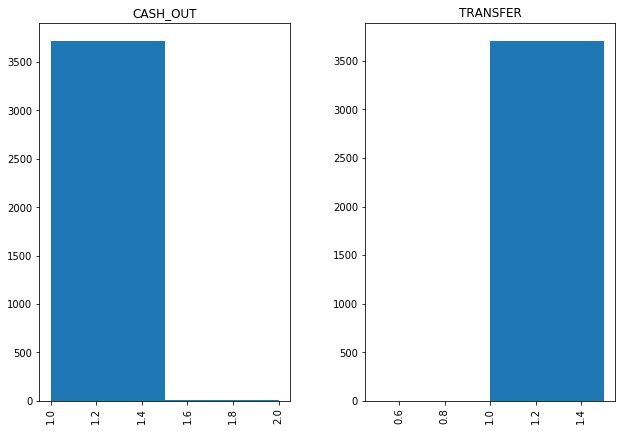

In [94]:
# repetive frauds

all_frauds_orig = data.loc[data['isFraud']==1].groupby(['nameOrig','type'])['isFraud'].count().reset_index(name="fraudCnt")
all_frauds_orig.rename(columns={'nameOrig':'name'},inplace = True)
display_side_by_side(all_frauds_orig.head(),all_frauds_orig.loc[all_frauds_orig['fraudCnt'] > 1].head(), titles=['Orig frauds','fraud Count > 1'])


all_frauds_dest = data.loc[data['isFraud']==1].groupby(['nameDest','type'])['isFraud'].count().reset_index(name="fraudCnt")
all_frauds_dest.rename(columns={'nameDest':'name'},inplace = True)
display_side_by_side(all_frauds_dest.head(),all_frauds_dest.loc[all_frauds_dest['fraudCnt'] > 1].head(), titles=['Dest frauds','fraud Count > 1'])

all_fraud_cnt = all_frauds_orig.append(all_frauds_dest)
all_fraud_cnt = all_fraud_cnt.groupby(['name','type'])['fraudCnt'].sum().reset_index(name="fraudCnt")
display_side_by_side(all_fraud_cnt.head(),all_fraud_cnt.loc[all_fraud_cnt['fraudCnt'] > 1].head(), titles=['All combined frauds','fraud Count > 1'])

all_fraud_cnt['fraudCnt'].hist(bins=2, figsize=(10, 7), by=all_fraud_cnt['type'])

In [95]:
all_nonfrauds_orig = data.loc[data['isFraud']==0].groupby(['nameOrig','type'])['isFraud'].count().reset_index(name="nonfraudCnt")
all_nonfrauds_orig.rename(columns={'nameOrig':'name'},inplace = True)
display(all_nonfrauds_orig.head())


all_nonfrauds_dest = data.loc[data['isFraud']==0].groupby(['nameDest','type'])['isFraud'].count().reset_index(name="nonfraudCnt")
all_nonfrauds_dest.rename(columns={'nameDest':'name'},inplace = True)
display(all_nonfrauds_dest.head())

all_nonfraud_cnt = all_nonfrauds_orig.append(all_nonfrauds_dest)
all_nonfraud_cnt = all_nonfraud_cnt.groupby(['name','type'])['fraudCnt'].sum().reset_index(name="nonfraudCnt")
display(all_nonfraud_cnt.head())

all_nonfraud_cnt['fraudCnt'].hist(bins=10, figsize=(10, 7), by=all_fraud_cnt['type'])

,name,type,nonfraudCnt
0,C1000000639,CASH_OUT,1
1,C1000001337,PAYMENT,1
2,C1000001725,PAYMENT,1
3,C1000002591,CASH_IN,1
4,C1000003372,CASH_IN,1


,name,type,nonfraudCnt
0,C1000004940,CASH_IN,2
1,C1000004940,CASH_OUT,7
2,C1000004940,TRANSFER,1
3,C1000013769,CASH_IN,4
4,C1000013769,CASH_OUT,3


KeyError: 'Column not found: fraudCnt'

In [29]:
data.sort_values(by=['step']).loc[(data['nameDest'] == 'C38997010') | (data['nameOrig'] == 'C38997010')]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,org_wthdrawls_fnlBlnce_right_flg,recalc_org_fnlBlnce,diff_org_fnl_balance,dtl_recalc_newbalance_org,recalc_vs_df_newbalance_org,sim_isFraud,origEntity_trxCnt_origPos,origEntity_trxCnt_destPos,name,origEntity_trxCnt
3,1,CASH_OUT,181.000,C840083671,181.000,0.000,C38997010,21182.000,0.000,1.000,...,right value,0.000,0.000,0.000,correct - equals,0,1,38,C840083671,1
30708,8,CASH_IN,20496.030,C1596340734,118148.000,138644.030,C38997010,0.000,0.000,0.000,...,right value,138644.030,0.000,138645.000,correct - equals,0,1,38,C1596340734,1
61572,9,CASH_OUT,561738.830,C1576788131,21378.000,0.000,C38997010,0.000,564088.170,0.000,...,wrong value,-540360.830,-540360.830,-540360.000,missing data - not talking negative values,1,1,38,C1576788131,1
73222,10,CASH_IN,145961.610,C981088659,61665.230,207626.840,C38997010,561738.830,564088.170,0.000,...,right value,207626.840,0.000,207627.000,correct - equals,0,1,38,C981088659,1
87369,10,CASH_OUT,148310.950,C1644157942,0.000,0.000,C38997010,415777.220,564088.170,0.000,...,wrong value,-148310.950,-148310.950,-148310.000,missing data - not talking negative values,0,1,38,C1644157942,1
155162,12,CASH_OUT,7688.840,C907436289,0.000,0.000,C38997010,564088.170,571777.010,0.000,...,wrong value,-7688.840,-7688.840,-7688.000,missing data - not talking negative values,0,1,38,C907436289,1
187937,13,CASH_OUT,89181.110,C1873538043,29222.000,0.000,C38997010,571777.010,660958.120,0.000,...,wrong value,-59959.110,-59959.110,-59959.000,missing data - not talking negative values,0,1,38,C1873538043,1
241989,14,CASH_IN,234935.670,C2037433356,4901483.420,5136419.100,C38997010,791512.500,1371837.430,0.000,...,right value,5136419.090,-0.010,5136420.000,correct - equals,1,1,38,C2037433356,1
259529,14,CASH_OUT,89906.780,C154348958,0.000,0.000,C38997010,556576.820,1371837.430,0.000,...,wrong value,-89906.780,-89906.780,-89906.000,missing data - not talking negative values,0,1,38,C154348958,1
237017,14,CASH_OUT,130554.380,C653268388,0.000,0.000,C38997010,660958.120,1371837.430,0.000,...,wrong value,-130554.380,-130554.380,-130554.000,missing data - not talking negative values,0,1,38,C653268388,1


### not many Orig entities have more than 1 fraud reported

### check if fraudulent trans occure on repetive Dest customers

In [ ]:
# repetive frauds

all_frauds_dest = data.loc[data['isFraud']==1].groupby('nameDest')['isFraud'].sum().reset_index(name="fraudCnt")
all_frauds_orig.rename(columns={'nameDest':'name'},inplace = True)
display_side_by_side(all_frauds_orig.head(),all_frauds_orig.loc[all_frauds_orig['fraudCnt'] > 1].head(), titles=['Dest frauds','fraud Count > 1'])


all_frauds_dest = data.loc[data['isFraud']==1].groupby('nameDest')['isFraud'].sum().reset_index(name="fraudCnt")
all_frauds_dest.rename(columns={'nameDest':'name'},inplace = True)
display_side_by_side(all_frauds_dest.head(),all_frauds_dest.loc[all_frauds_dest['fraudCnt'] > 1].head(), titles=['Dest frauds','fraud Count > 1'])

all_fraud_cnt = all_frauds_orig.append(all_frauds_dest)
all_fraud_cnt = all_fraud_cnt.groupby('name')['fraudCnt'].sum().reset_index(name="fraudCnt")
display_side_by_side(all_fraud_cnt.head(),all_fraud_cnt.loc[all_fraud_cnt['fraudCnt'] > 1].head(), titles=['All combined frauds','fraud Count > 1'])

all_fraud_cnt['fraudCnt'].hist(bins=2, figsize=(10, 7))

In [ ]:
### check the count of previous transactions per tran type

# '
# '
# '
# continue from here

### 7)collect all orig/den that are involed in a fraud (isFraud = 1)

In [17]:
# collect all orig/den that are involed in a fraud (isFraud = 1)

org = data[['org_ind','nameOrig','type','isFraud']].loc[data['isFraud']==1].rename(columns = {'org_ind':'ind','nameOrig':'name'})
org['direction'] = 'O'
den = data[['den_ind','nameDest','type','isFraud']].loc[data['isFraud']==1].rename(columns = {'den_ind':'ind','nameDest':'name'})
den['direction'] = 'D'

nn1 = org.append(den)

nn1 = nn1.drop_duplicates()

display(describe(nn1, [ 'sum']))
display(nn1.groupby(['ind','direction','type']).count())



,isFraud
count,7429.000
mean,1.000
std,0.000
min,1.000
25%,1.000
50%,1.000
75%,1.000
max,1.000
sum,7429.000


name  isFraud
ind direction               
C   D          3704     3704
    O          3725     3725

In [ ]:
# 8)create direction of transactions overall for each entity within the dataset

In [ ]:
an originator customer has senders when it's cash in and has receivers for the rest
a  destination customer has senders for the rest and receivers for Cash_in

how to count entities that are both senders and receivers and avoin double count

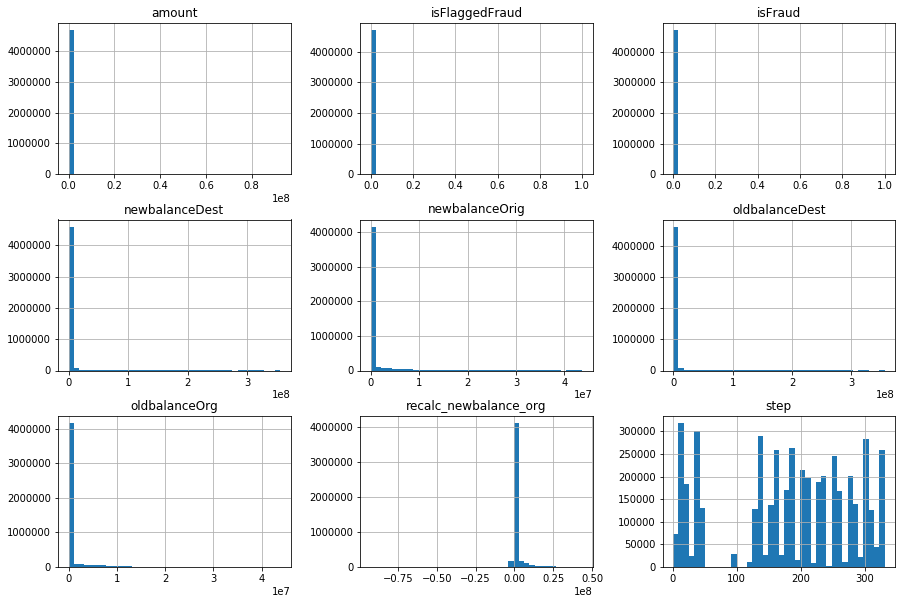

In [17]:

data.hist(bins=40, figsize=(15, 10), sharex=False, sharey=False)
plt.ticklabel_format(style='plain')
plt.show()

step


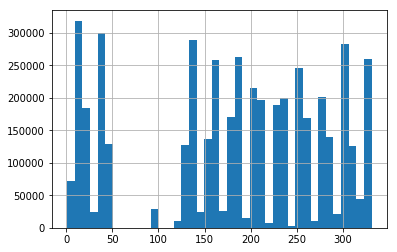

amount


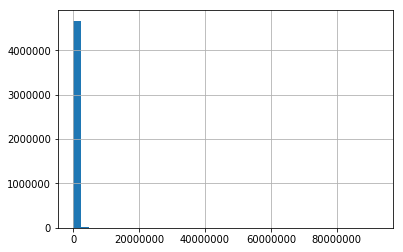

oldbalanceOrg


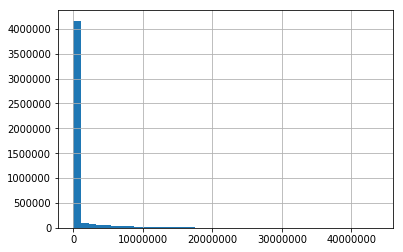

newbalanceOrig


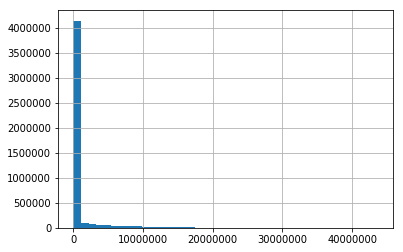

oldbalanceDest


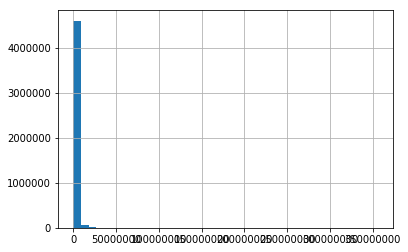

newbalanceDest


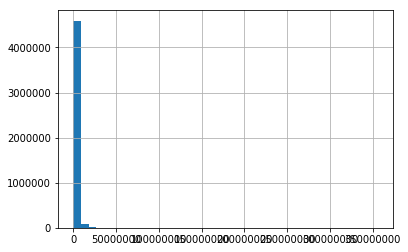

isFraud


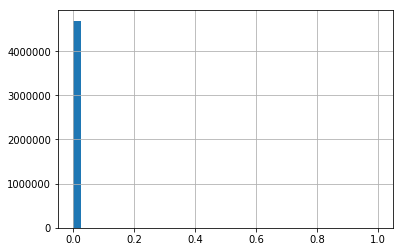

isFlaggedFraud


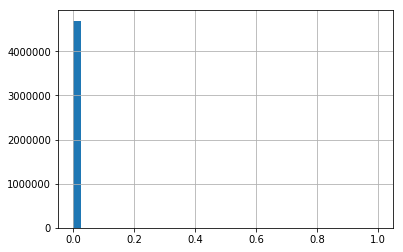

recalc_newbalance_org


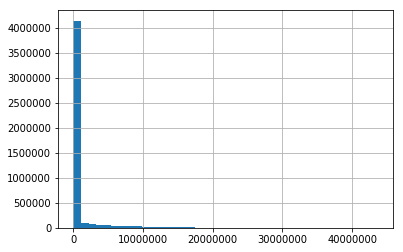

amt_gt_initBalance


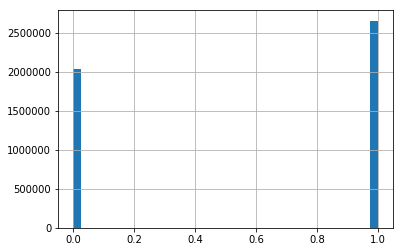

In [24]:
num_cols = data.select_dtypes(include=np.number).columns.tolist()

for col in num_cols:
    print(col)
    data[col].hist(bins=40)
    plt.ticklabel_format(style='plain')
    plt.show()